This notebook reads in two SLCs and plots an igram, and saves it. 

This notebook was copied and edited 8-15-23.

***

Import things. Use conda environment oliviaJupyter.

In [1]:
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from dateutil import parser
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib  widget

Define working directory, crop directory, dates we want to load in, and dimensions of raw SLCs. 

In [2]:
workdir = '/data/ocp4/LagunaSalada/Data_and_Figs/'
#cropdir='cropped_9000_20_10000_1780'
cropdir='cropped_9000_1800_18000_3600'                                     

datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1

x1=0
dx=18000 #dx=10000
y1=0
dy=3600 #dy=1780
# filter size
alooks=4
rlooks=20

precip = np.loadtxt('/data/ocp4/LagunaSalada/Data_and_Figs/3_precip/precip_cumulative.txt')
driver=gdal.GetDriverByName('ISCE')

In [3]:
print('i\tprecip')
for i in range(nd):
    if precip[i]>0.0:
        print(str(i)+'\t'+str(precip[i]))

i	precip
0	0.33020000000000005
8	0.254
10	0.0762
11	0.127
23	0.050800000000000005
25	0.050800000000000005
42	0.050800000000000005
47	5.0546
48	0.10160000000000001
50	0.5334
51	0.22860000000000003
52	0.4572
53	0.10160000000000001
55	0.27940000000000004
59	0.10160000000000001
74	1.4478
83	2.286
84	1.016
85	1.016
86	0.254
87	0.1778
90	0.9398
97	1.4224
102	3.6321999999999997
103	0.254
107	1.7272
154	2.2098
155	0.025400000000000002
186	0.381
190	0.7112
196	0.2286
209	0.889


Which interferogram to plot? Give the index. 

In [4]:
i=46

date1: 20181125	 precip: 0.0
date2: 20181207	 precip: 5.0546


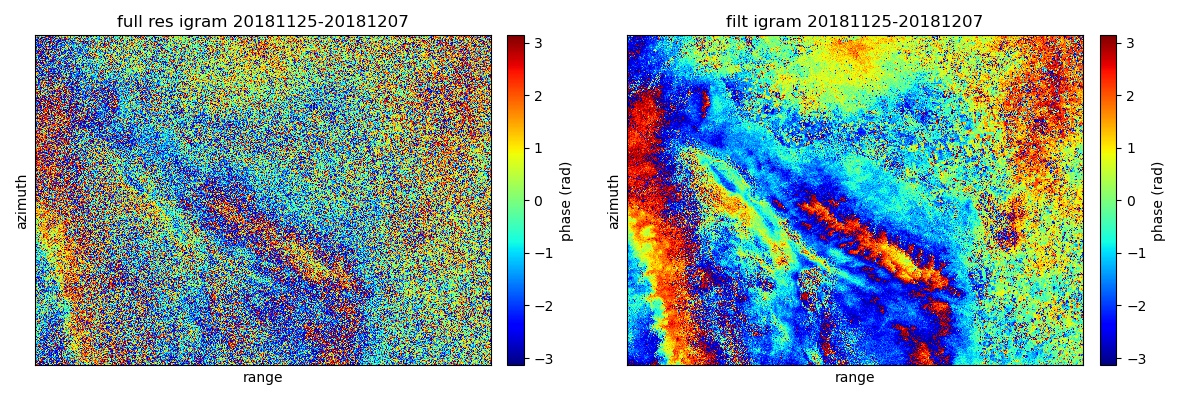

In [5]:
date1 = dates[i]; date2 = dates[i+1]
print('date1: '+str(date1)+'\t precip: '+str(precip[i]))
print('date2: '+str(date2)+'\t precip: '+str(precip[i+1]))
# load in SLCs
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x1,y1,dx,dy)
# calculate igram
int12 = slc1 * np.conj(slc2)
# filter it 
s1=slc1*np.conj(slc1)
s2=slc2*np.conj(slc2)
a1r=gaussian_filter(np.real(s1), sigma=[alooks/4,rlooks/4])
a1i=gaussian_filter(np.imag(s1), sigma=[alooks/4,rlooks/4])
a2r=gaussian_filter(np.real(s2), sigma=[alooks/4,rlooks/4])
a2i=gaussian_filter(np.imag(s2), sigma=[alooks/4,rlooks/4])
a1 = a1r+1j*a1i
a2 = a2r+1j*a2i
filtimager=gaussian_filter(np.real(int12), sigma=[alooks/4,rlooks/4])
filtimagei=gaussian_filter(np.imag(int12), sigma=[alooks/4,rlooks/4])
filtimage = filtimager+1j*filtimagei
scaler    = np.sqrt(a1*a2)
filtimage = filtimage/scaler
int12filt = np.angle(filtimage)
# plot full res and filt versions 
plt.figure(figsize=(12,4),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(np.angle(int12),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='auto', interpolation='nearest')
plt.xlim(dx, 0)
plt.title('full res igram '+str(date1)+'-'+str(date2))
plt.xlabel('range')
plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.colorbar(label='phase (rad)',pad=0.03)
plt.subplot(1,2,2)
plt.imshow(int12filt,vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='auto', interpolation='nearest')
plt.xlim(dx, 0)
plt.title('filt igram '+str(date1)+'-'+str(date2))
plt.xlabel('range')
plt.ylabel('azimuth')
plt.xticks([]); plt.yticks([])
plt.colorbar(label='phase (rad)',pad=0.03)
plt.show()

Save it as an .r4 ISCE-readable file for converting to tif with gdal and plotting in PyGMT. 

In [8]:
#fileName = '/data/ocp4/LagunaSalada/Data_and_Figs/16_PyGMT/Fig2_A/'+date1+'_'+date2+'_unfilt_entire_crop_area.r4'
fileName = '/data/ocp4/LagunaSalada/Data_and_Figs/16_PyGMT/Fig2_A/'+date1+'_'+date2+'_filt_entire_crop_area.r4'
print('saving: '+fileName)
# colds = driver.Create(fileName,dx,dy,1,gdal.GDT_Float32)
# colds.GetRasterBand(1).WriteArray(np.angle(int12))
# colds=None
colds = driver.Create(fileName,dx,dy,1,gdal.GDT_Float32)
colds.GetRasterBand(1).WriteArray(int12filt)
colds=None

saving: /data/ocp4/LagunaSalada/Data_and_Figs/16_PyGMT/Fig2_A/20181125_20181207_filt_entire_crop_area.r4
